In [1]:
import os
import typing

# Dask Configuration

In [2]:
from dask_jobqueue import PBSCluster
from pathlib import Path

# Define the working directory path
working_directory = str(Path.cwd())

# Launch a scheduler and workers on HPC via PBS
cluster = PBSCluster(
     cores=4,
     memory="8GB",
     processes=1,
     queue="tamirQ",
     walltime="02:30:00",
     scheduler_options={"dashboard_address": ":12435"},  # FIXME - this is the port we need to define...
     # Additional custom options
     log_directory="dask-logs",
     #worker_extra_args=["--lifetime", "25m", "--lifetime-stagger", "4m"],  # for walltime="00:30:00"
     job_script_prologue=[f"cd {working_directory}"]
)

In [3]:
cluster

Dashboard: http://132.66.112.146:12435/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://132.66.112.146:41568,Workers: 0
Dashboard: http://132.66.112.146:12435/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
cluster.adapt(minimum=30, maximum=60)
print(cluster.job_script())

#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q tamirQ
#PBS -l select=1:ncpus=4:mem=7630MB
#PBS -l walltime=02:30:00
#PBS -e dask-logs/
#PBS -o dask-logs/
cd /tamir2/moranb/microbiome/Igem_TAU_2021
/tamir2/moranb/microbiome/Igem_TAU_2021/venv/bin/python -m distributed.cli.dask_worker tcp://132.66.112.146:41568 --nthreads 4 --memory-limit 7.45GiB --name dummy-name --nanny --death-timeout 60



In [5]:
from dask.distributed import Client, progress, wait, get_client, get_worker
client = Client(cluster)

In [6]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://132.66.112.146:12435/status,
Dashboard: http://132.66.112.146:12435/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://132.66.112.146:41568,Workers: 0
Dashboard: http://132.66.112.146:12435/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [7]:
import dask.bag as db
import dask.dataframe as dd
from dask import delayed, compute, persist
from pandas.core.dtypes.common import pandas_dtype as dtype
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path

/tamir2/moranb/microbiome/Igem_TAU_2021/venv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Analysis for homo sapiens genes

In [8]:
import operator
from Bio import SeqIO
from analysis.input_testing_data.generate_input_testing_data_for_modules import generate_testing_data
from analysis.input_testing_data.generate_input_testing_data_for_modules import generate_testing_data_for_ecoli_and_bacillus

from modules.main import run_modules
from modules.user_IO.input_functions import extract_gene_data

In [9]:
output_path = "/tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens"
optimization_cub_index = "CAI"

variant_names = [
    "{score}_single_diff",
    "{score}_zscore_single_diff",
    "{score}_zscore_bulk_diff",
    "{score}_single_ratio",
    "{score}_zscore_single_ratio",
    "{score}_zscore_bulk_ratio",
]

average_distance_variant_names = [s.format(score="average_distance_score") for s in variant_names]

In [10]:
def get_configuration(is_ecoli_optimized):
    return f"e_coli_optimized_{is_ecoli_optimized}_bacillus_optimized_{not is_ecoli_optimized}"

In [11]:
def get_orf_summary(summary: typing.Dict[str, typing.Any], evaluation_method: str = "average_distance_score") -> typing.Dict[str, typing.Any]:
    if len(summary["evaluation"]) == 1:
        return summary["orf"]
    final_evaluation = summary["final_evaluation"]
    for i, evaluation_summary in enumerate(summary["evaluation"]):
        if evaluation_summary[evaluation_method] == final_evaluation[evaluation_method]:
            return summary["orf"][i]

def get_total_run_time(summary: typing.Dict[str, typing.Any]) -> float:
     if len(summary["evaluation"]) == 1:
        return summary["orf"]["run_time"]
     run_time = 0
     for orf_summary in summary["orf"]:
         run_time += orf_summary["run_time"]
     return run_time

In [12]:
def convert_json(x):
    gene_name = x["gene_name"]
    result = x["summary"]
    orf = get_orf_summary(result)
    if "orf" not in result or orf is None: # probably thrown in case of an error
        return {"error": result, "gene_name": gene_name}
    run_time = get_total_run_time(result)
    iterations_count = str(orf.get("iterations_count", 1))
    return {
        "initial_optimization_score": orf.get("initial_sequence_optimization_score"),
        "final_optimization_score": orf.get("final_sequence_optimization_score"),
        "average_distance_score": result["final_evaluation"].get("average_distance_score"),
        "average_distance_non_normalized_score": result["final_evaluation"].get("average_distance_non_normalized_score"),
        "weakest_link_score": result["final_evaluation"].get("weakest_link_score"),
        "ratio_score": result["final_evaluation"].get("ratio_score"),
        "gene_name": gene_name,
        "orf_optimization_cub_index": result["module_input"].get("orf_optimization_cub_index"),
        "evaluation_score": result["module_input"].get("evaluation_score"),
        "run_time": run_time,
        "iterations_count": iterations_count,
        "final_sequence": result["final_evaluation"].get("final_sequence"),
    }

In [13]:
def json_map(x):
    x = x.strip("\n")
    result = None
    try:
        result = json.loads(x)
        return convert_json(result)
    except Exception as e:
        if result is None:
            return {"error_message": "bad json string", "input": x}
        return {"error_message": e}

In [14]:
def get_df_for_run_configuration(configuration, optimization_method, is_debug=False):
    configuration_output_path = os.path.join(output_path, configuration)
    debug_suffix = '-debug' if is_debug else ''
    results_dir = F"{os.path.join(configuration_output_path, optimization_method + debug_suffix)}"
    print(f"results dir is: {results_dir}")
    file_names = [str(file) for file in list(Path(results_dir).rglob("*.json"))]
    # bag = db.read_text(file_names).map(json.loads)
    bag = db.read_text(file_names).map(json_map)

    error_records = bag.filter(lambda x: "error_message" in x.keys())
    valid_records = bag.filter(lambda x: "error_message" not in x.keys())
    return valid_records.to_dataframe().compute(), error_records.compute()

    # return dd.read_json([str(file) for file in list(Path(results_dir).rglob("*.json"))], orient='records', lines=True)

In [15]:
def get_scores_df_by_configuration_df(configuration, is_debug=False):
    df_bulk_zscore_ratio, df_bulk_zscore_ratio_errors = get_df_for_run_configuration(configuration, "zscore_bulk_aa_ratio", is_debug)
    df_bulk_zscore_diff, df_bulk_zscore_diff_errors = get_df_for_run_configuration(configuration, "zscore_bulk_aa_diff", is_debug)
    merged_bulk_zscore_df = dd.merge(df_bulk_zscore_ratio, df_bulk_zscore_diff, on='gene_name', how='inner', suffixes=('_zscore_bulk_ratio', '_zscore_bulk_diff'))

    df_single_zscore_ratio, df_single_zscore_ratio_errors = get_df_for_run_configuration(configuration, "zscore_single_aa_ratio", is_debug)
    df_single_zscore_diff, df_single_zscore_diff_errors = get_df_for_run_configuration(configuration, "zscore_single_aa_diff", is_debug)
    merged_single_zscore_df = dd.merge(df_single_zscore_ratio, df_single_zscore_diff, on='gene_name', how='inner', suffixes=('_zscore_single_ratio', '_zscore_single_diff'))

    df_single_codon_ratio, df_single_codon_ratio_error = get_df_for_run_configuration(configuration, "single_codon_ratio", is_debug)
    df_single_codon_diff, df_single_codon_diff_error = get_df_for_run_configuration(configuration, "single_codon_diff", is_debug)
    merged_single_df = dd.merge(df_single_codon_ratio, df_single_codon_diff, on='gene_name', how='inner', suffixes=('_single_ratio', '_single_diff'))

    merged_df = dd.merge(merged_bulk_zscore_df, merged_single_zscore_df, on='gene_name', how='inner')
    merged_df = dd.merge(merged_df, merged_single_df, on='gene_name', how='inner')
    # merged_df = dd.merge(merged_bulk_zscore_df, merged_single_df, on='gene_name', how='inner')
    return merged_df, [
        df_bulk_zscore_ratio_errors,
        df_bulk_zscore_diff_errors, 
        df_single_zscore_ratio_errors, 
        df_single_zscore_diff_errors, 
        df_single_codon_ratio_error,
        df_single_codon_diff_error,
    ]

In [16]:
def get_scores_df_by_configuration(configuration, is_debug=False):
    df_bulk_zscore_ratio, df_bulk_zscore_ratio_errors = get_df_for_run_configuration(configuration, "zscore_bulk_aa_ratio", is_debug)
    df_bulk_zscore_diff, df_bulk_zscore_diff_errors = get_df_for_run_configuration(configuration, "zscore_bulk_aa_diff", is_debug)

    df_single_codon_ratio, df_single_codon_ratio_error = get_df_for_run_configuration(configuration, "single_codon_ratio", is_debug)
    df_single_codon_diff, df_single_codon_diff_error = get_df_for_run_configuration(configuration, "single_codon_diff", is_debug)

    return [
        df_bulk_zscore_ratio,
        df_bulk_zscore_diff,
        df_single_codon_ratio,
        df_single_codon_diff,
    ], [
        df_bulk_zscore_ratio_errors,
        df_bulk_zscore_diff_errors, 
        df_single_zscore_ratio_errors, 
        df_single_zscore_diff_errors, 
        df_single_codon_ratio_error,
        df_single_codon_diff_error,
    ]

In [17]:
def add_median_to_histogram(value, histogram, row, col, upper_limit):
    median_value = value.median()
    histogram[row][col].axvline(median_value, color="green", linestyle="dashed", label="median")
    histogram[row][col].text(median_value-1, upper_limit, f"median={median_value}")

In [18]:
def add_median_to_histogram_non_normalized(value, histogram, row, col, upper_limit):
    median_value = value.median()
    histogram[row][col].axvline(median_value, color="green", linestyle="dashed", label="median")
    histogram[row][col].text(median_value-0.1, upper_limit, f"median={median_value}")

In [19]:
def plot_comparative_graphs(result):
    figure, axis = plt.subplots(8, 2, figsize=(20,35))

    index = 0
    for i, first_variant in enumerate(average_distance_variant_names):
        for j, second_variant in enumerate(average_distance_variant_names):
            if j <= i:
                continue 
            scatter = result.plot.scatter(x=first_variant, y=second_variant, ax=axis[index//2, index%2])
            r, p = stats.pearsonr(result[first_variant], result[second_variant])
            print(first_variant)
            print(result[first_variant].isnull().sum())
            scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')
            index += 1

#### Escherichia-coli as wanted host 

In [20]:
configuration = get_configuration(is_ecoli_optimized=True)
result, errors = get_scores_df_by_configuration_df(configuration)

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_True_bacillus_optimized_False/zscore_bulk_aa_ratio


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_True_bacillus_optimized_False/zscore_bulk_aa_diff


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_True_bacillus_optimized_False/zscore_single_aa_ratio


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_True_bacillus_optimized_False/zscore_single_aa_diff


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_True_bacillus_optimized_False/single_codon_ratio


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_True_bacillus_optimized_False/single_codon_diff


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

In [21]:
result

,initial_optimization_score_zscore_bulk_ratio,final_optimization_score_zscore_bulk_ratio,average_distance_score_zscore_bulk_ratio,average_distance_non_normalized_score_zscore_bulk_ratio,weakest_link_score_zscore_bulk_ratio,ratio_score_zscore_bulk_ratio,gene_name,orf_optimization_cub_index_zscore_bulk_ratio,evaluation_score_zscore_bulk_ratio,run_time_zscore_bulk_ratio,...,final_optimization_score_single_diff,average_distance_score_single_diff,average_distance_non_normalized_score_single_diff,weakest_link_score_single_diff,ratio_score_single_diff,orf_optimization_cub_index_single_diff,evaluation_score_single_diff,run_time_single_diff,iterations_count_single_diff,final_sequence_single_diff
0,1.174602,1.322601,1.637405,0.043850,1.637405,1.081754,lcl|NC_000001.11_cds_NP_004082.1_2089,CAI,average_distance,134.449720,...,None,0.927619,0.091665,0.927619,1.038303,CAI,average_distance,0.641059,1,ATGCTGCAAGGGCCCCGGGCCTTGGCTTCGGCCGCTGGGCAGACCC...
1,1.099118,1.328557,2.036872,0.067241,2.036872,1.093783,lcl|NC_000001.11_cds_NP_002158.3_2095,CAI,average_distance,141.257531,...,None,1.403750,0.125792,1.403750,1.053788,CAI,average_distance,0.276351,1,ATGAAGGCGCTGAGCCCGGTGCGCGGCTGCTACGAGGCGGTGTGCT...
2,1.021302,1.342124,2.181910,0.104460,2.181910,1.098423,lcl|NC_000001.11_cds_NP_000966.2_2096,CAI,average_distance,134.444363,...,None,2.145271,0.168939,2.145271,1.086259,CAI,average_distance,0.569381,1,ATGGCGCAGGATCAAGGTGAAAAGGAGAACCCCATGCGGGAACTTC...
3,1.036729,1.379780,2.452041,0.125606,2.452041,1.117420,lcl|NC_000001.11_cds_NP_001005484.2_1,CAI,average_distance,139.033873,...,None,2.467890,0.209476,2.467890,1.102004,CAI,average_distance,0.621479,1,ATGAAGAAGGTAACTGCAGAGGCTATTTCCTGGAATGAATCAACGT...
4,1.053415,1.346952,2.688983,0.109470,2.688983,1.125407,lcl|NC_000001.11_cds_XP_047292308.1_2,CAI,average_distance,151.083149,...,None,1.868132,0.161729,1.868132,1.071342,CAI,average_distance,0.963480,1,ATGCCTAGACACACACATCCTTACTCTGCGTGCATCCCTGGCCTGG...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20033,1.017603,1.389280,2.534471,0.127583,2.534471,1.124984,lcl|NC_000023.11_cds_NP_060666.1_130659,CAI,average_distance,58.821538,...,None,2.432186,0.192914,2.432186,1.104702,CAI,average_distance,0.025010,1,ATGTGGTACCACAGATTGTCCCACCTACACAGCAGGCTTCAGGACC...
20034,1.175824,1.336640,1.913211,0.060221,1.913211,1.097525,lcl|NC_000024.10_cds_NP_870996.1_130922,CAI,average_distance,58.940929,...,None,1.025468,0.087784,1.025468,1.043503,CAI,average_distance,0.010258,1,ATGAGTCCAAAGCCGAGAGCCTCGGGACCTCCGGCCAAGGCCAAGG...
20035,1.107890,1.346430,2.299405,0.085528,2.299405,1.115226,lcl|NC_000023.11_cds_NP_001381283.1_130666,CAI,average_distance,59.328713,...,None,1.785318,0.140549,1.785318,1.074955,CAI,average_distance,0.197635,1,ATGGATGCTGCGGTGACAGATGATTTTCAACAAATTCTGCCTATTG...
20036,1.156751,1.295340,1.123052,0.001035,1.123052,1.057225,lcl|NC_000023.11_cds_NP_001007525.1_130657,CAI,average_distance,60.020465,...,None,0.631309,0.069325,0.631309,1.026383,CAI,average_distance,0.017013,1,ATGGCGGCAGCGGCTGCAGGCCTGGGCGGCGGCGGCGCCGGCCCGG...


In [22]:
filtered_result = result[result["average_distance_score_zscore_bulk_ratio"].notna()]

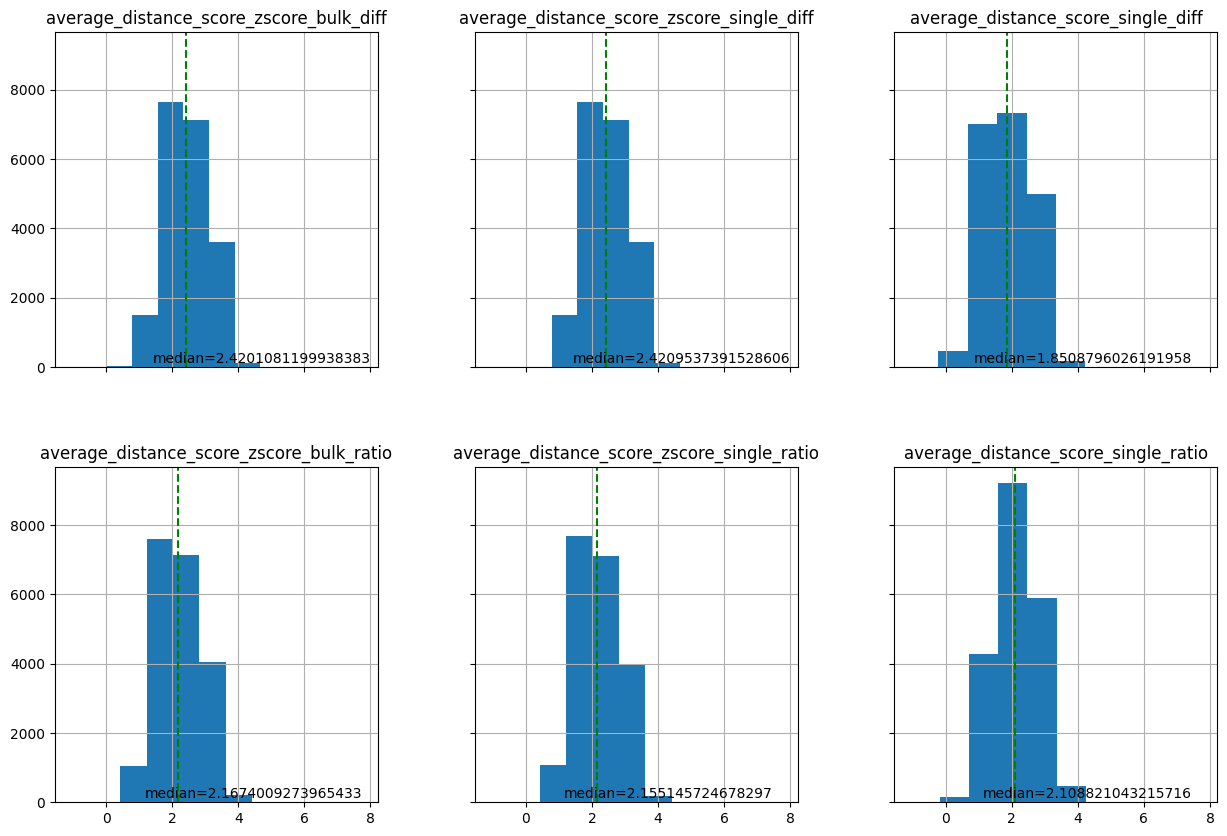

In [23]:
score_type = "average_distance"
histogram = filtered_result[[
    f"{score_type}_score_zscore_bulk_diff",
    f"{score_type}_score_zscore_single_diff", 
    f"{score_type}_score_single_diff", 
    f"{score_type}_score_zscore_bulk_ratio", 
    f"{score_type}_score_zscore_single_ratio",
    f"{score_type}_score_single_ratio",
]].hist(sharex=True, sharey=True,figsize=(15, 10), layout=(2,3))

median_height = 120
add_median_to_histogram(result[f"{score_type}_score_zscore_bulk_diff"], histogram, 0, 0, median_height)
add_median_to_histogram(result[f"{score_type}_score_zscore_single_diff"], histogram, 0, 1, median_height)
add_median_to_histogram(result[f"{score_type}_score_single_diff"], histogram, 0, 2, median_height)

add_median_to_histogram(result[f"{score_type}_score_zscore_bulk_ratio"], histogram, 1, 0, median_height)
add_median_to_histogram(result[f"{score_type}_score_zscore_single_ratio"], histogram, 1, 1, median_height)
add_median_to_histogram(result[f"{score_type}_score_single_ratio"], histogram, 1, 2, median_height)

In [27]:
single_diff_negative = filtered_result[filtered_result["average_distance_score_single_diff"] < 0] 
single_ratio_negative = filtered_result[filtered_result["average_distance_score_single_ratio"] < 0] 

zscore_bulk_diff_negative = filtered_result[filtered_result["average_distance_score_zscore_bulk_diff"] < 0] 
zscore_bulk_ratio_negative = filtered_result[filtered_result["average_distance_score_zscore_bulk_ratio"] < 0]

zscore_single_diff_negative = filtered_result[filtered_result["average_distance_score_zscore_single_diff"] < 0] 
zscore_single_ratio_negative = filtered_result[filtered_result["average_distance_score_zscore_single_ratio"] < 0] 

print(f"{len(single_diff_negative)}, percentage:{len(single_diff_negative)/len(result) * 100}")
print(f"{len(single_ratio_negative)}, percentage:{len(single_ratio_negative)/len(result) * 100}")
print(zscore_single_ratio_negative["gene_name"])
print(f"{len(zscore_bulk_diff_negative)}, percentage:{len(zscore_bulk_diff_negative)/len(result) * 100}")
print(f"{len(zscore_bulk_ratio_negative)}, percentage:{len(zscore_bulk_ratio_negative)/len(result) * 100}")
print(f"{len(zscore_single_diff_negative)}, percentage:{len(zscore_single_diff_negative)/len(result) * 100}")
print(f"{len(zscore_single_ratio_negative)}, percentage:{len(zscore_single_ratio_negative)/len(result) * 100}")

21, percentage:0.10480087833117079
18, percentage:0.08982932428386066
13677    lcl|NC_000014.9_cds_92019
Name: gene_name, dtype: object
0, percentage:0.0
1, percentage:0.0049905180157700365
0, percentage:0.0
1, percentage:0.0049905180157700365


average_distance_score_single_diff
0
average_distance_score_single_diff
0
average_distance_score_single_diff
0
average_distance_score_single_diff
0
average_distance_score_single_diff
0
average_distance_score_zscore_single_diff
0
average_distance_score_zscore_single_diff
0
average_distance_score_zscore_single_diff
0
average_distance_score_zscore_single_diff
0
average_distance_score_zscore_bulk_diff
0
average_distance_score_zscore_bulk_diff
0
average_distance_score_zscore_bulk_diff
0
average_distance_score_single_ratio
0
average_distance_score_single_ratio
0
average_distance_score_zscore_single_ratio
0


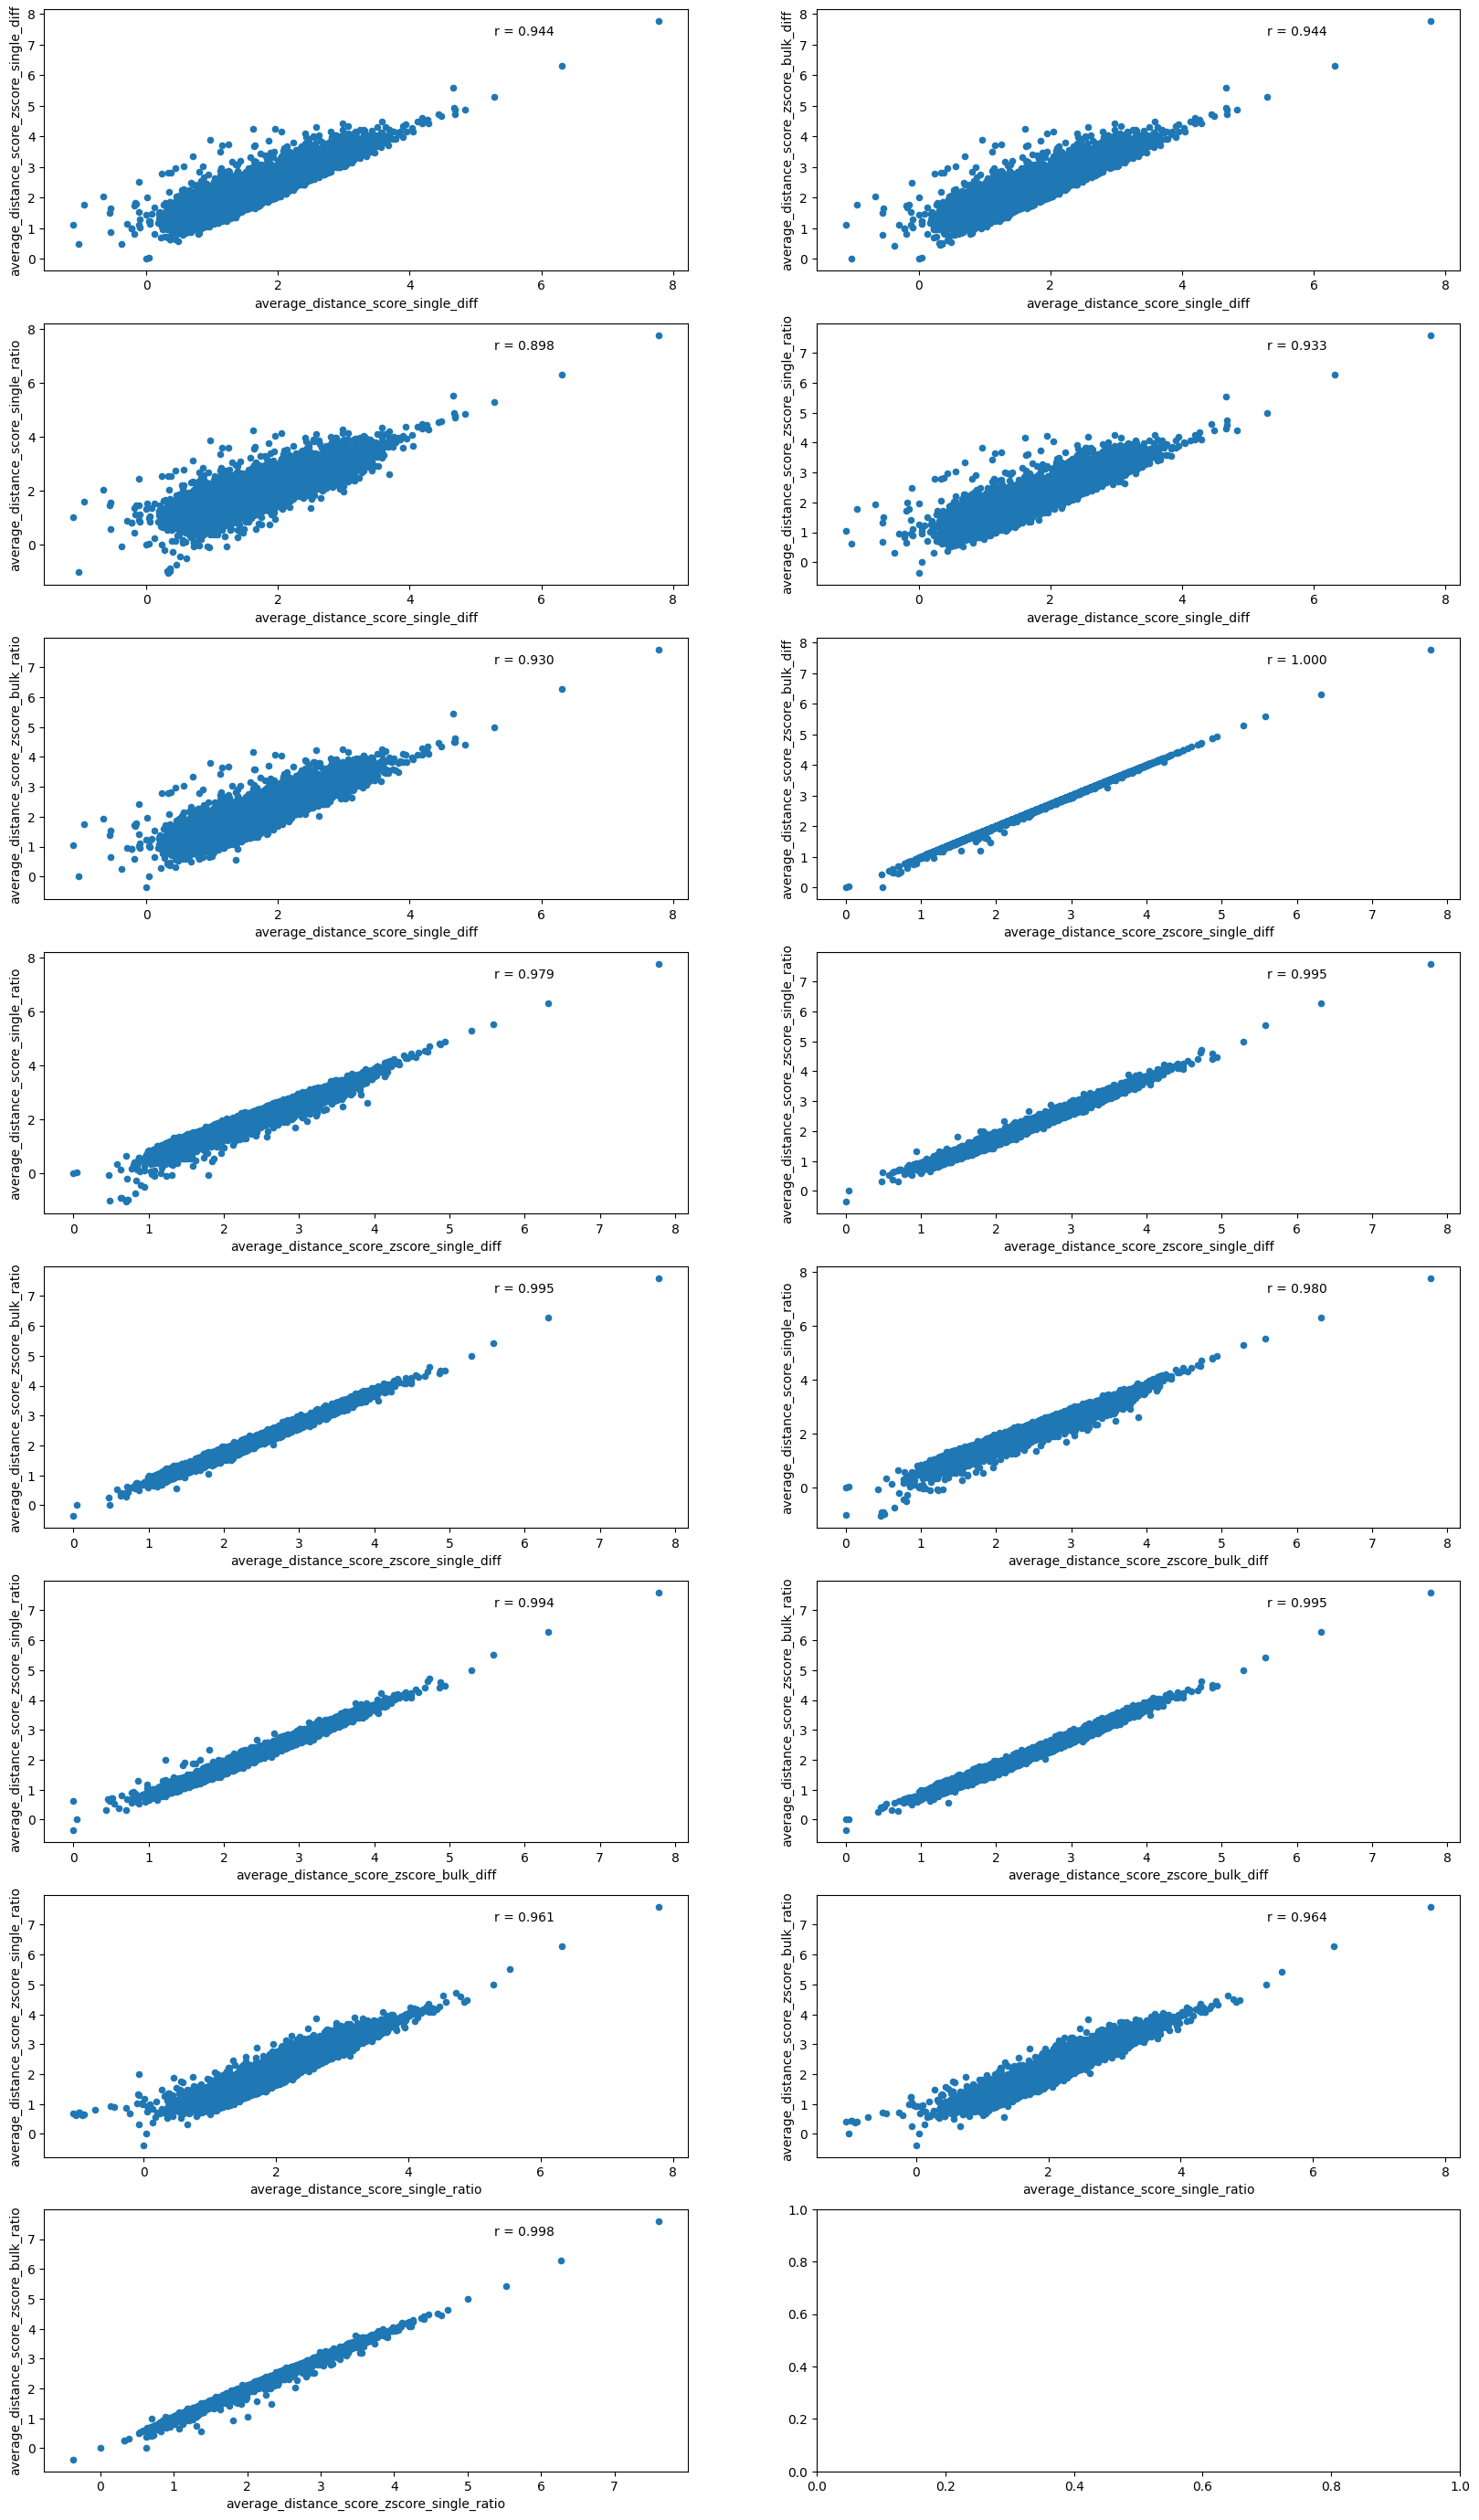

In [25]:
plot_comparative_graphs(filtered_result)

#### Escherichia-coli as unwanted host 

In [34]:
configuration = get_configuration(is_ecoli_optimized=False)
result, errors = get_scores_df_by_configuration_df(configuration)

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_False_bacillus_optimized_True/zscore_bulk_aa_ratio


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_False_bacillus_optimized_True/zscore_bulk_aa_diff


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_False_bacillus_optimized_True/zscore_single_aa_ratio


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_False_bacillus_optimized_True/zscore_single_aa_diff


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_False_bacillus_optimized_True/single_codon_ratio


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_False_bacillus_optimized_True/single_codon_diff


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

In [35]:
filtered_result = result[result["average_distance_score_zscore_bulk_ratio"].notna()]

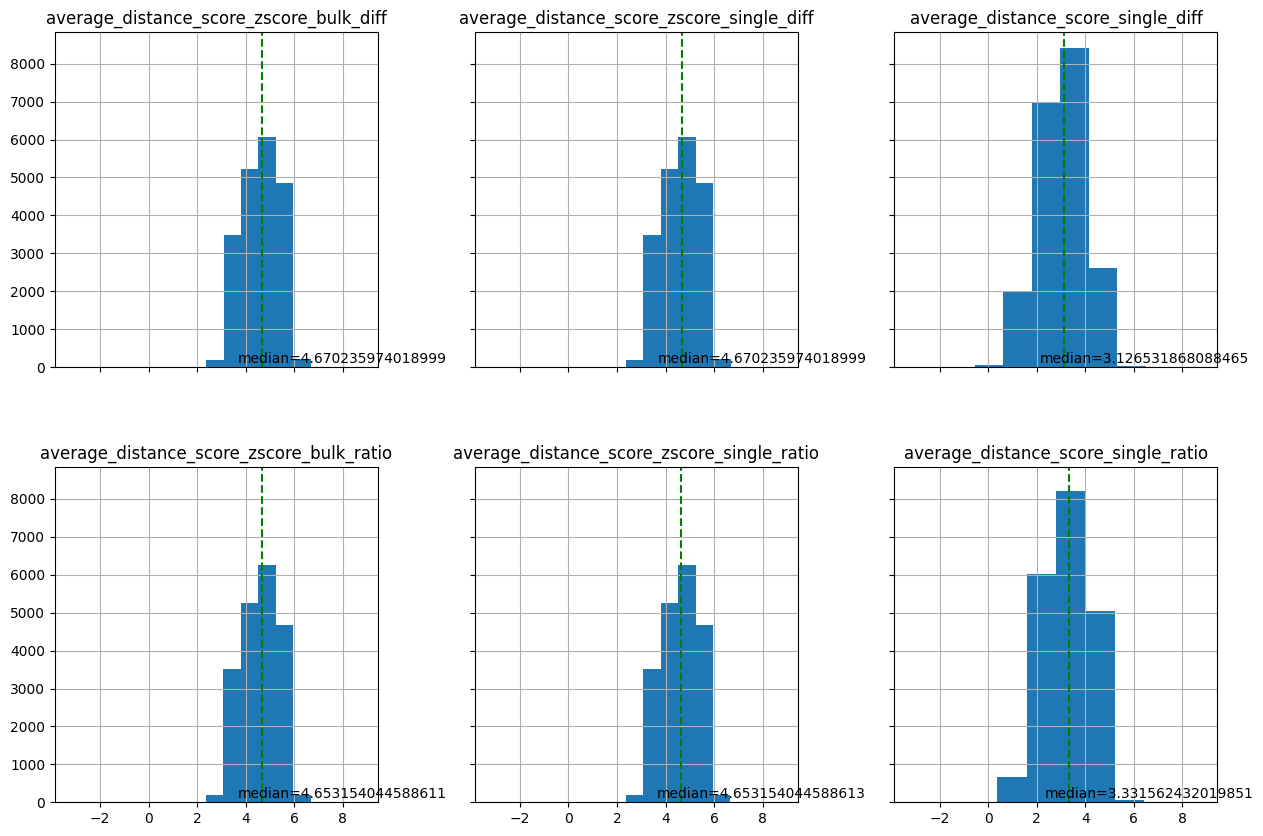

In [36]:
score_type = "average_distance"
histogram = filtered_result[[
    f"{score_type}_score_zscore_bulk_diff",
    f"{score_type}_score_zscore_single_diff", 
    f"{score_type}_score_single_diff", 
    f"{score_type}_score_zscore_bulk_ratio", 
    f"{score_type}_score_zscore_single_ratio",
    f"{score_type}_score_single_ratio",
]].hist(sharex=True, sharey=True,figsize=(15, 10), layout=(2,3))

median_height = 120
add_median_to_histogram(result[f"{score_type}_score_zscore_bulk_diff"], histogram, 0, 0, median_height)
add_median_to_histogram(result[f"{score_type}_score_zscore_single_diff"], histogram, 0, 1, median_height)
add_median_to_histogram(result[f"{score_type}_score_single_diff"], histogram, 0, 2, median_height)

add_median_to_histogram(result[f"{score_type}_score_zscore_bulk_ratio"], histogram, 1, 0, median_height)
add_median_to_histogram(result[f"{score_type}_score_zscore_single_ratio"], histogram, 1, 1, median_height)
add_median_to_histogram(result[f"{score_type}_score_single_ratio"], histogram, 1, 2, median_height)

average_distance_score_single_diff
0
average_distance_score_single_diff
0
average_distance_score_single_diff
0
average_distance_score_single_diff
0
average_distance_score_single_diff
0
average_distance_score_zscore_single_diff
0
average_distance_score_zscore_single_diff
0
average_distance_score_zscore_single_diff
0
average_distance_score_zscore_single_diff
0
average_distance_score_zscore_bulk_diff
0
average_distance_score_zscore_bulk_diff
0
average_distance_score_zscore_bulk_diff
0
average_distance_score_single_ratio
0
average_distance_score_single_ratio
0
average_distance_score_zscore_single_ratio
0


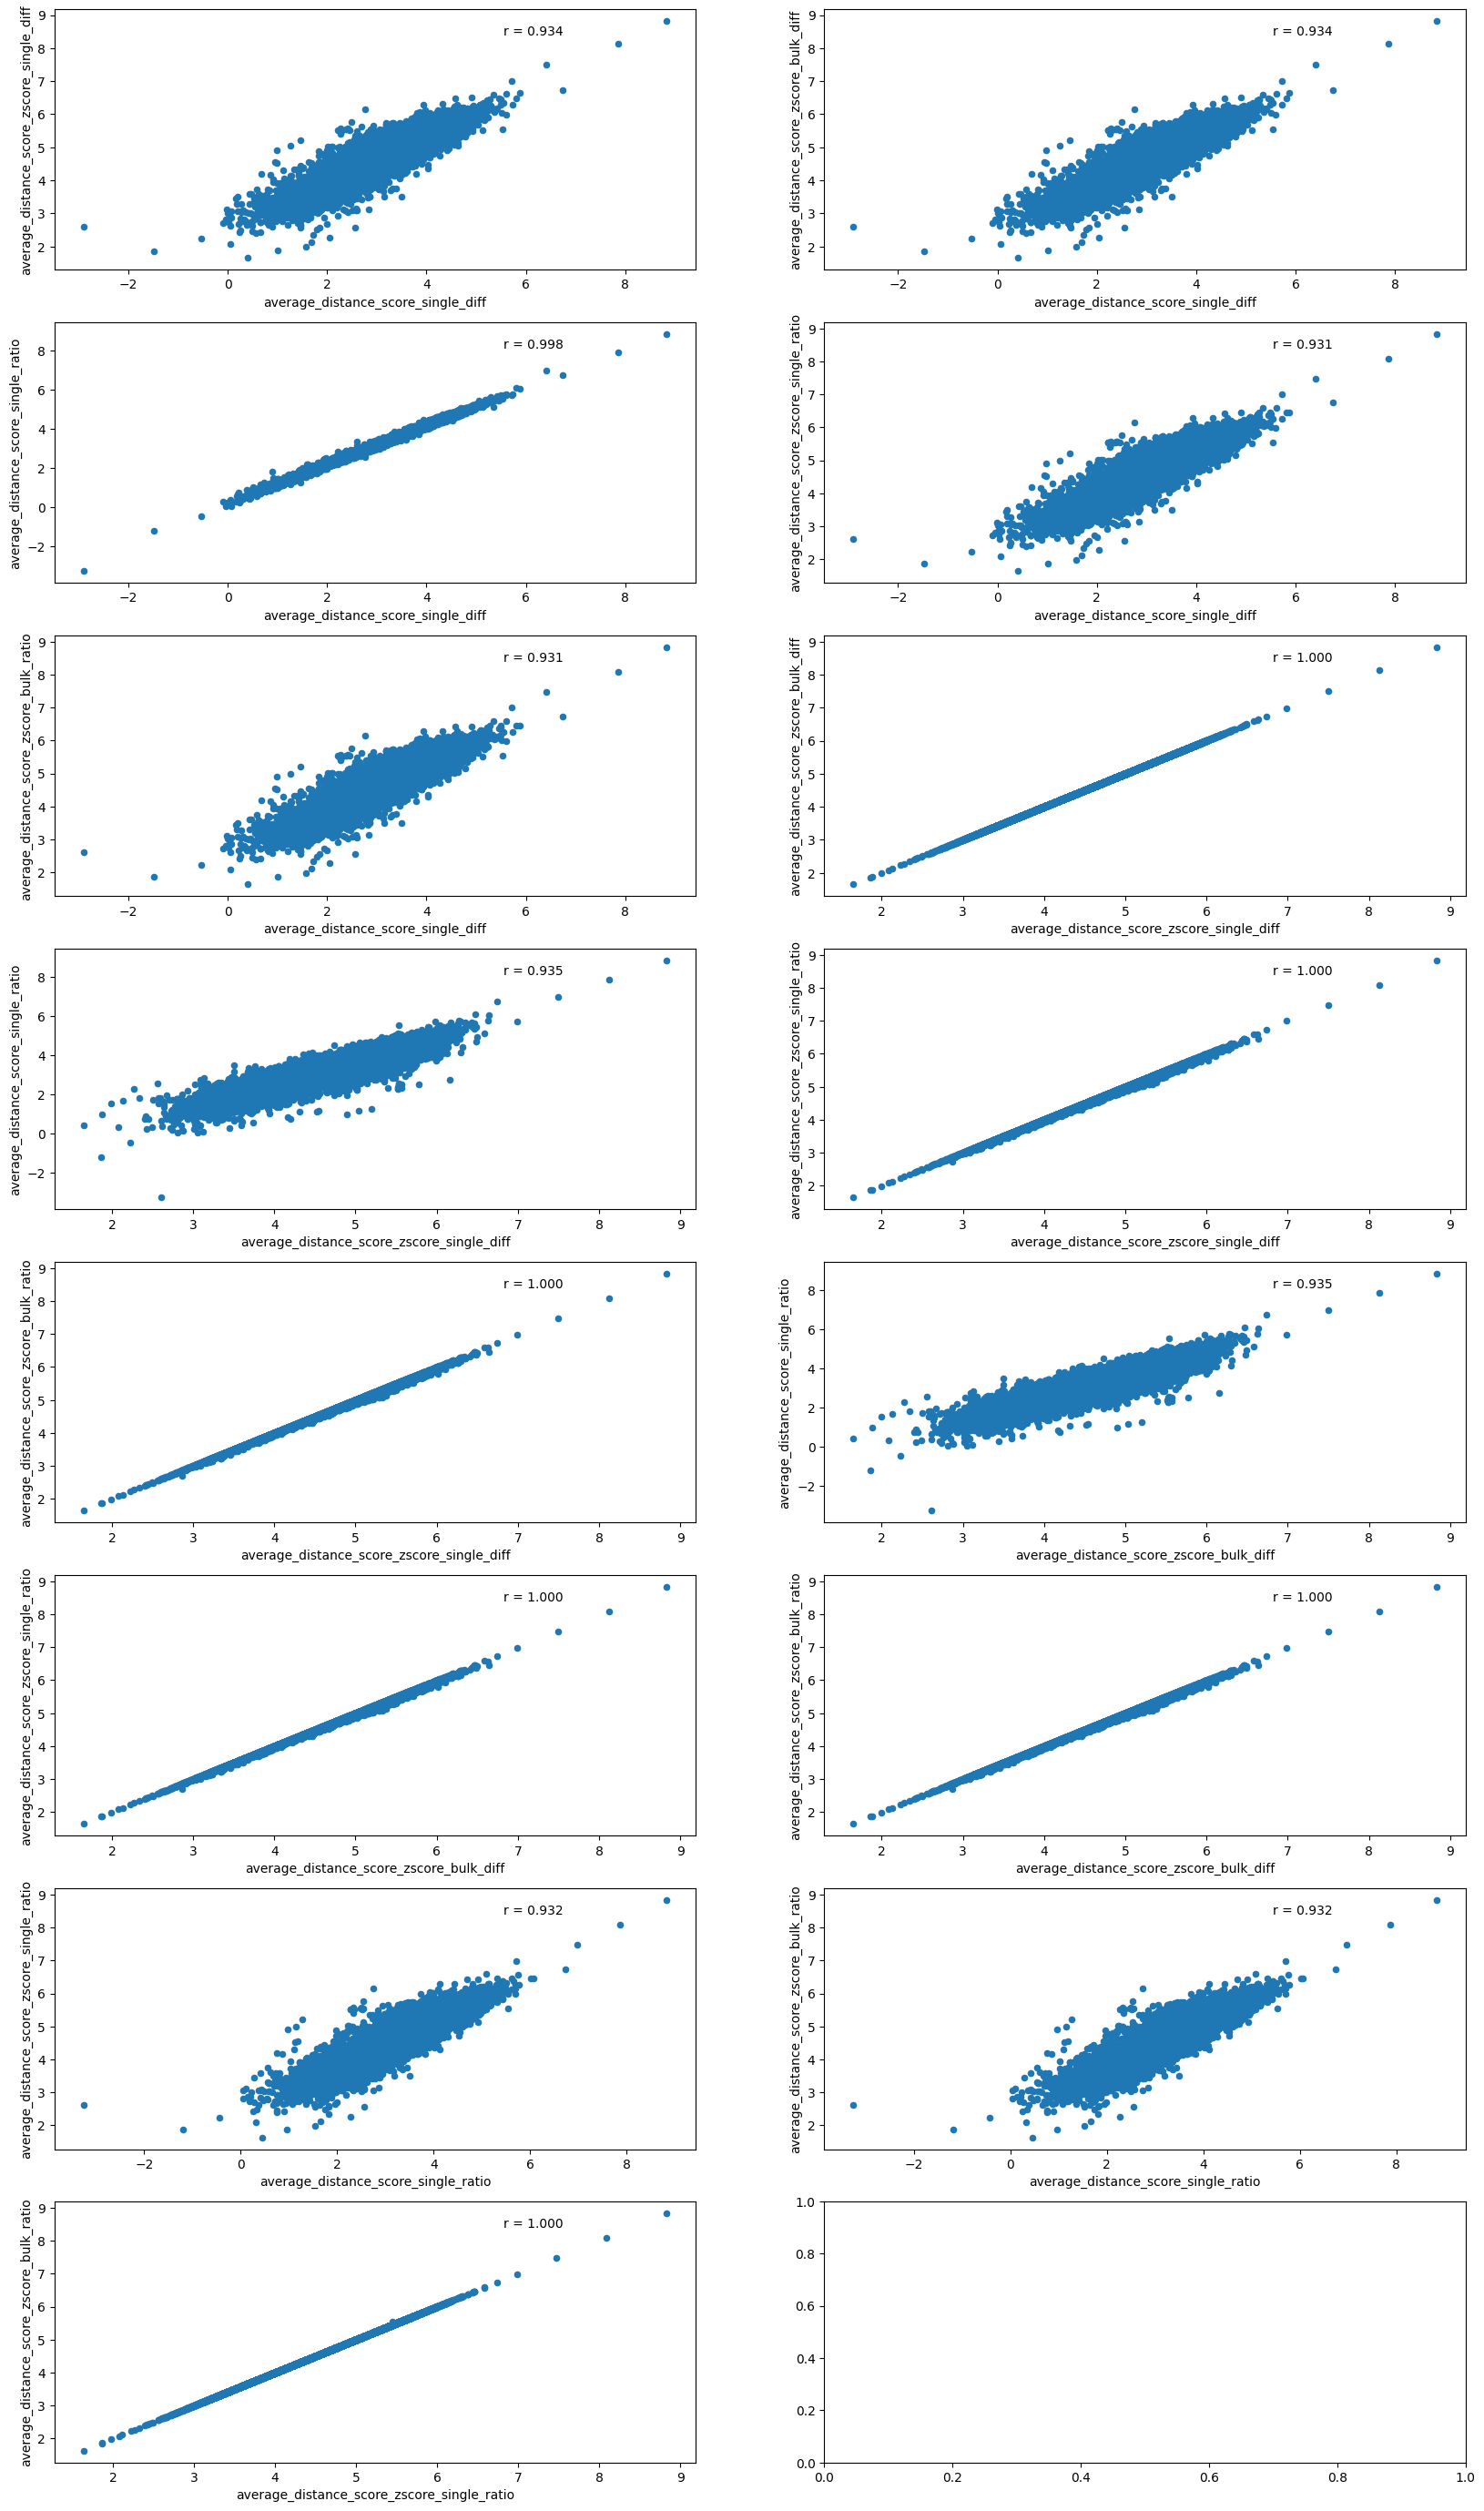

In [38]:
plot_comparative_graphs(result)

In [37]:
single_diff_negative = result[result["average_distance_score_single_diff"] < 0] 
single_ratio_negative = result[result["average_distance_score_single_ratio"] < 0] 

zscore_bulk_diff_negative = result[result["average_distance_score_zscore_bulk_diff"] < 0] 
zscore_bulk_ratio_negative = result[result["average_distance_score_zscore_bulk_ratio"] < 0]

zscore_single_diff_negative = result[result["average_distance_score_zscore_single_diff"] < 0] 
zscore_single_ratio_negative = result[result["average_distance_score_zscore_single_ratio"] < 0] 

print(f"{len(single_diff_negative)}, percentage:{len(single_diff_negative)/len(result) * 100}")
print(f"{len(single_ratio_negative)}, percentage:{len(single_ratio_negative)/len(result) * 100}")
print(f"{len(zscore_bulk_diff_negative)}, percentage:{len(zscore_bulk_diff_negative)/len(result) * 100}")
print(f"{len(zscore_bulk_ratio_negative)}, percentage:{len(zscore_bulk_ratio_negative)/len(result) * 100}")
print(f"{len(zscore_single_diff_negative)}, percentage:{len(zscore_single_diff_negative)/len(result) * 100}")
print(f"{len(zscore_single_ratio_negative)}, percentage:{len(zscore_single_ratio_negative)/len(result) * 100}")

6, percentage:0.029938625817074998
3, percentage:0.014969312908537499
0, percentage:0.0
0, percentage:0.0
0, percentage:0.0
0, percentage:0.0
